We gonna try to colorize images from black and white images, through an architecture of convolutional neural networks called autoencoder, something that is turning pretty common now with the colorization of old - movies and scenes.


The dataset (and also, better codes and explanations on the subject) can be found at:


https://www.kaggle.com/theblackmamba31/landscape-image-colorization



In [1]:
from keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, Reshape ,Input, MaxPool2D, UpSampling2D , concatenate, BatchNormalization
from keras.models import Model,Sequential 
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import numpy as np 
import keras.backend as K
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.utils import plot_model
from keras.models import save_model, load_model

In [2]:
DIRcolor = '/content/drive/MyDrive/Datasets/landscape Images/color'
DIRgrey = '/content/drive/MyDrive/Datasets/landscape Images/gray'

color = ['/content/drive/MyDrive/Datasets/landscape Images/color/{}'.format(i) for i in os.listdir(DIRcolor)]
grey = ['/content/drive/MyDrive/Datasets/landscape Images/gray/{}'.format(i) for i in os.listdir(DIRgrey)]

In [3]:
grey = sorted(grey)
color = sorted(color)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


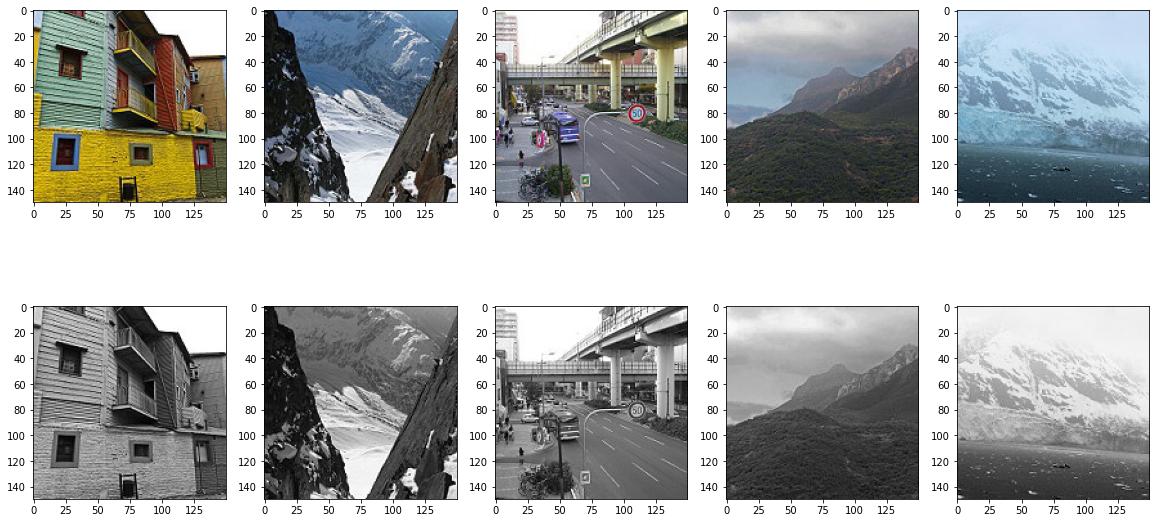

In [4]:
plt.figure(figsize = (20,10))


z = 1
for i in range(1,11):
  plt.subplot(2,5,i)
  plt.imshow(Image.open(color[i]))
  if i >= 6:
    plt.subplot(2,5,i)
    plt.imshow(Image.open(grey[z]), cmap = 'gray')
    z+=1


In [5]:
xcolor = []
xg= [] 




def Rnp(lm):


  for i in lm:
    img = cv2.imread(i)
    img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB) #o método cv2 passa as imagens para  BGR, através desse código retornaremos a imagem para RGB
    img = cv2.resize(img , (160,160))
    img = img.astype('float32') / 255
    xcolor.append(img)
    
def RnpG(lm):

  for i in lm:
    img = cv2.imread(i)
    img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img , (160,160))
    img = img.astype('float32') / 255
    xg.append(img)

Rnp(color)
RnpG(grey)

In [6]:
xcolor = np.reshape(xcolor , [-1, 160 , 160 , 3])
xgrey = np.reshape(xg ,[-1,160,160,1] )

In [7]:
xgrey

array([[[[0.38039216],
         [0.3372549 ],
         [0.40784314],
         ...,
         [0.2901961 ],
         [0.2901961 ],
         [0.29411766]],

        [[0.78039217],
         [0.72156864],
         [0.7019608 ],
         ...,
         [0.26666668],
         [0.2627451 ],
         [0.27058825]],

        [[0.46666667],
         [0.7372549 ],
         [0.80784315],
         ...,
         [0.2627451 ],
         [0.28627452],
         [0.29803923]],

        ...,

        [[0.14509805],
         [0.16078432],
         [0.12941177],
         ...,
         [0.13725491],
         [0.08627451],
         [0.11764706]],

        [[0.14901961],
         [0.1254902 ],
         [0.09411765],
         ...,
         [0.06666667],
         [0.04705882],
         [0.04313726]],

        [[0.08627451],
         [0.10980392],
         [0.14901961],
         ...,
         [0.07058824],
         [0.07843138],
         [0.04705882]]],


       [[[0.10980392],
         [0.87058824],
         [0.83

In [8]:
input_shape = [160,160,1]

inputs = Input(shape = input_shape, name = 'encoder_inputs')
filters = [64,128,256,512,1024]
x = inputs
for filter in filters:
  x = Conv2D(filters = filter, kernel_size= 3,
         strides = 2,padding = 'same',
         activation = 'relu')(x)


shape = K.int_shape(x)

x = Flatten()(x)

latentv= Dense(256 , name = 'latent_vector' )(x)

encoder = Model(inputs, latentv , name = 'encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, 160, 160, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 512)       1180160   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 1024)        4719616   
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0   

In [9]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, 160, 160, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 512)       1180160   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 1024)        4719616   
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0   

In [10]:
shape

(None, 5, 5, 1024)

In [11]:
latent_inputs = Input(shape = (256,) , name = 'decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1] , shape[2] , shape[3]))(x)

for filter in filters[::-1]:
  x = Conv2DTranspose(filters = filter, kernel_size= 3,
                  strides =2, padding ='same' , 
                  activation = 'relu')(x)


Outputs = Conv2DTranspose(filters = 3, kernel_size = 3,
                          activation = 'sigmoid' , padding = 'same')(x)


decoder = Model(latent_inputs , Outputs, name = 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 25600)             6579200   
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 10, 1024)      9438208   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 20, 512)       4719104   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 40, 40, 256)       1179904   
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 80, 80, 128)       2950

In [12]:
autoencoder = Model(inputs , decoder(encoder(inputs)) , name = 'autoencoder')
autoencoder.summary()


Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, 160, 160, 1)]     0         
_________________________________________________________________
encoder (Functional)         (None, 256)               12823296  
_________________________________________________________________
decoder (Functional)         (None, 160, 160, 3)       22286979  
Total params: 35,110,275
Trainable params: 35,110,275
Non-trainable params: 0
_________________________________________________________________


Architecture Diagra of an Autoencoder (sees that the dimension are reduced to posteriorly be incremented)


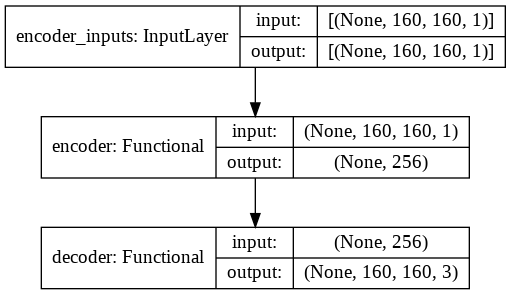

In [13]:
plot_model(autoencoder, show_shapes= True)

In [14]:
LR = ReduceLROnPlateau(monitor = 'loss' , patience = 1 , 
                       verbose = 1)

savefile = '/content/drive/MyDrive/Colab Notebooks/Paisagens/colorization.h5'
cp = ModelCheckpoint(savefile,
                     monitor = 'loss', 
                     verbose = 1,
                     save_best_only = True,
                     save_weights = True)


autoencoder.compile(optimizer = 'adam' , loss = 'mse' , metrics = ['acc'])

In [15]:
autoencoder.fit(xgrey,xcolor,epochs = 15, callbacks = (LR,cp))

Epoch 1/15
223/223 [==============================] - 88s 237ms/step - loss: 0.0545 - acc: 0.3234

Epoch 00001: loss improved from inf to 0.04048, saving model to /content/drive/MyDrive/Colab Notebooks/Paisagens/colorization.h5
Epoch 2/15
223/223 [==============================] - 51s 230ms/step - loss: 0.0274 - acc: 0.4116

Epoch 00002: loss improved from 0.04048 to 0.02657, saving model to /content/drive/MyDrive/Colab Notebooks/Paisagens/colorization.h5
Epoch 3/15
223/223 [==============================] - 52s 231ms/step - loss: 0.0242 - acc: 0.4199

Epoch 00003: loss improved from 0.02657 to 0.02383, saving model to /content/drive/MyDrive/Colab Notebooks/Paisagens/colorization.h5
Epoch 4/15
223/223 [==============================] - 51s 230ms/step - loss: 0.0225 - acc: 0.4410

Epoch 00004: loss improved from 0.02383 to 0.02208, saving model to /content/drive/MyDrive/Colab Notebooks/Paisagens/colorization.h5
Epoch 5/15
223/223 [==============================] - 51s 230ms/step - loss:

In [16]:
pred = autoencoder.predict(xgrey[:10])

In [27]:
autoencoder.evaluate(xgrey,xcolor)

223/223 [==============================] - 21s 94ms/step - loss: 0.0158 - acc: 0.5977


[0.0157613568007946, 0.5976612567901611]

This code was inspired by the code of the dataset, which you can find in the link at the header of this notebook

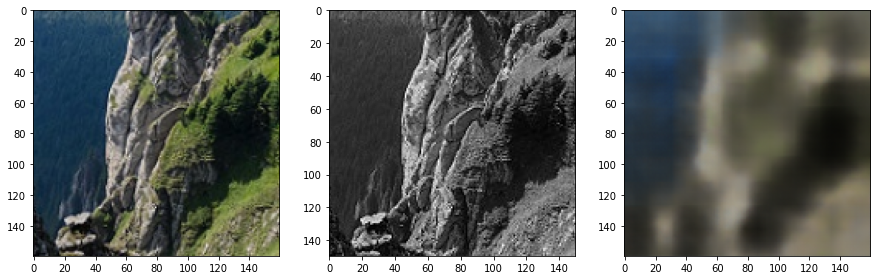

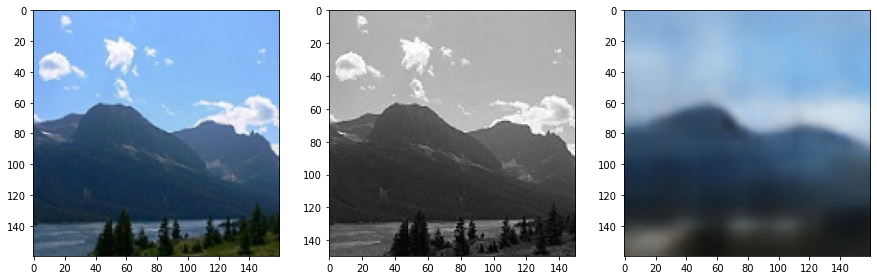

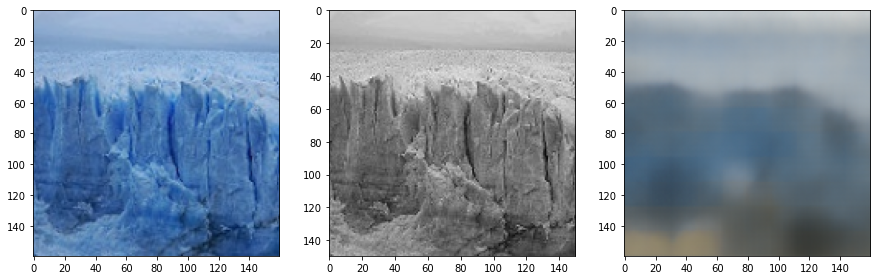

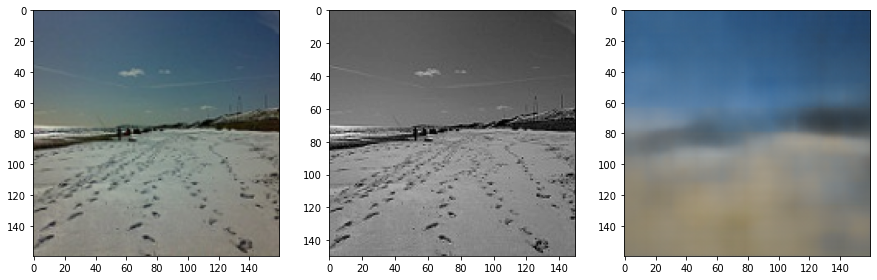

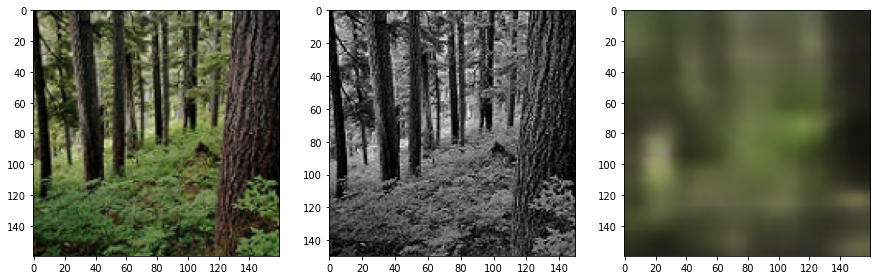

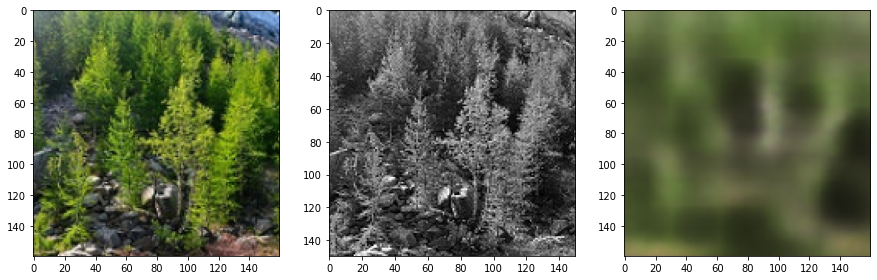

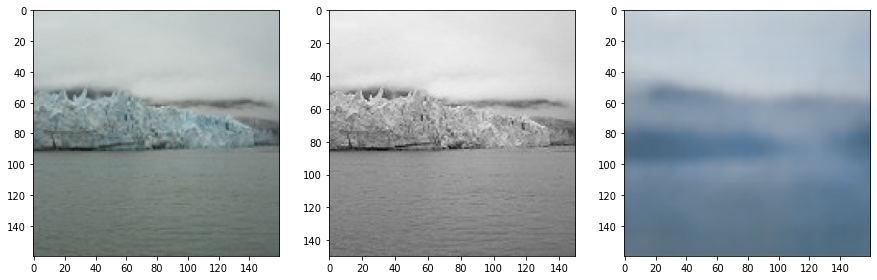

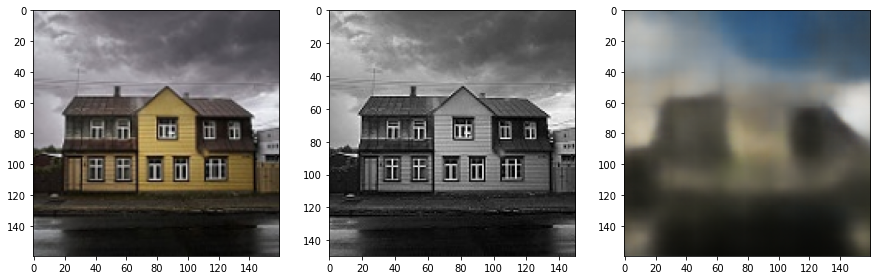

In [26]:
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.imshow(np.asarray(Image.open(grayscale)) , cmap = 'gray')
    plt.subplot(1,3,3)
    plt.imshow(predicted)
   
    plt.show()

for i in range(200,208):
    predicted = np.clip(autoencoder.predict(xgrey[i].reshape(1,160, 160,1)),0.0,1.0).reshape(160, 160,3)
    plot_images(xcolor[i],grey[i],predicted)

I took the grayscale image and merged it with the predicted colorization in photoshop, probably is a technique that can be used to better up the quality. Maintaining the edges and shapes (from the black and white image) and the colorization output by the neural network.

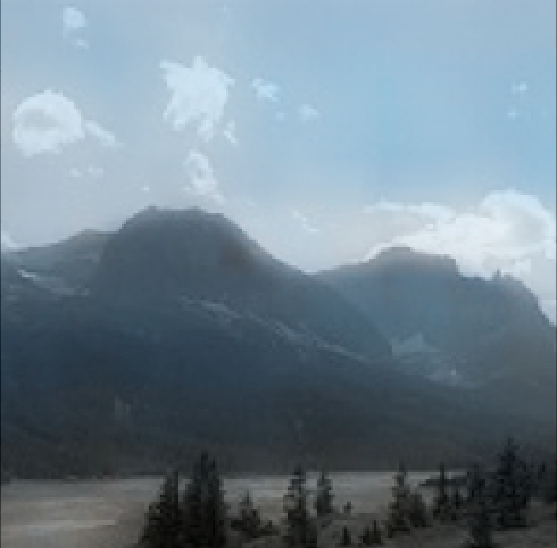

In [28]:
Image.open('/content/drive/MyDrive/Datasets/landscape Images/x.png')

**Discussion**

As you can see the predicted images are pretty blurry, this may be caused by the training epochs being so little or could be resolved through some insertions of information coming from decoding layers. 

But, this is all I can achieve now, by my lack of knowledge about this subject. Also, the notebook is being run in a free account of google collab (I have limitations in RAM usage and time-spend in the GPU, which made it impossible to run through more epochs ).

I'm very curious about the total power of this algorithm, but it's something that will not be possible at the moment to conclude.
